# CS6140 PROJECT:
# Convolutional Neural Network Model Powered Animal Image

# Yihao Shu,  Xianwei Long

# shu.yih@northeastern.edu, long.xianw@northeastern.edu

# Get start: Download the dataset

In [ ]:
'''
@article{beery2020iwildcam,
    title={The iWildCam 2020 Competition Dataset},
    author={Beery, Sara and Cole, Elijah and Gjoka, Arvi},
    journal={arXiv preprint arXiv:2004.10340},
    year={2020}
}
'''

'\n@article{beery2020iwildcam,\n    title={The iWildCam 2020 Competition Dataset},\n    author={Beery, Sara and Cole, Elijah and Gjoka, Arvi},\n    journal={arXiv preprint arXiv:2004.10340},\n    year={2020}\n}\n'

In [ ]:
!pip install wilds

In [ ]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
import torchvision.transforms as transforms

# Load the full dataset, and download it if necessary
dataset = get_dataset(dataset="iwildcam", download=True)

# Get the training set
train_data = dataset.get_subset(
    "train",
    transform=transforms.Compose(
        [transforms.Resize((448, 448)), transforms.ToTensor()]
    ),
)

# Prepare the standard data loader
train_loader = get_train_loader("standard", train_data, batch_size=16)

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


100%|██████████| 11957420032/11957420032 [29:47<00:00, 6688694.69Byte/s]


Extracting data/iwildcam_v2.0/archive.tar.gz to data/iwildcam_v2.0

It took 32.71 minutes to download and uncompress the dataset.



In [ ]:
"""
option step:
Since unlabeled dataset has a 45GB size, so we dont use it in the current project to improve the efficiency.
But after downloading it, it is the same step as we do next.
"""
# # Load unlabeled data
# dataset = get_dataset(dataset="iwildcam", download=True, unlabeled=True)
# unlabeled_data = dataset.get_subset(
#     "test_unlabeled",
#     transform=transforms.Compose(
#         [transforms.Resize((448, 448)), transforms.ToTensor()]
#     ),
# )
# unlabeled_loader = get_train_loader("standard", unlabeled_data, batch_size=16)

'\noption step:\nSince unlabeled dataset has a 45GB size, so we dont use it in the current project to improve the efficiency.\nBut after downloading it, it is the same step as we do next.\n'

In [ ]:
from wilds.common.data_loaders import get_eval_loader

# Get the test set
test_data = dataset.get_subset(
    "test",
    transform=transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor()]
    ),
)

# Prepare the data loader
test_loader = get_eval_loader("standard", test_data, batch_size=16)



# Group the data based on location

In [ ]:
from wilds.common.grouper import CombinatorialGrouper

# Initialize grouper, which extracts domain information
# In this example, we form domains based on location
grouper = CombinatorialGrouper(dataset, ['location'])

In [ ]:
train_loader = get_train_loader(
    "group", train_data, grouper=grouper, n_groups_per_batch=2, batch_size=16
)

# Check the train loader

In [ ]:
import matplotlib.pyplot as plt
import torchvision

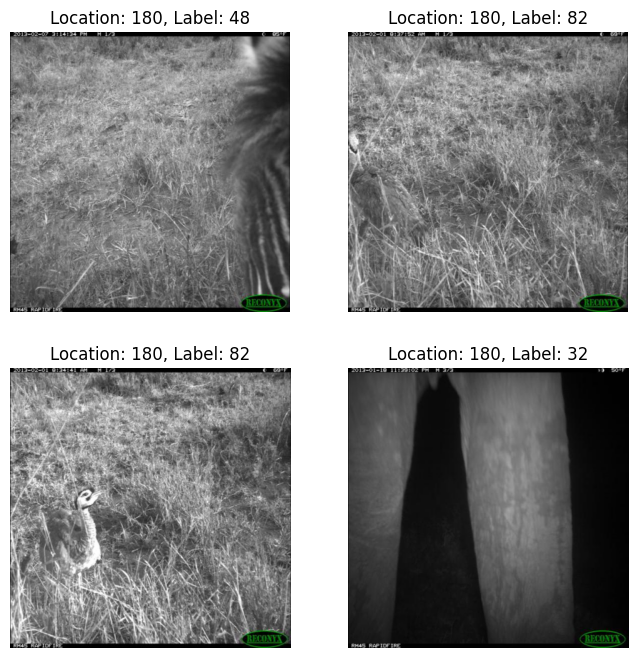

In [ ]:
for x, y_true, metadata in train_loader:
    z = grouper.metadata_to_group(metadata)

    # Display 4 images
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i in range(4):
        img = x[i]
        label = y_true[i].item()
        location = z[i].item()

        img_pil = torchvision.transforms.ToPILImage()(img)
        axs[i//2, i%2].imshow(img_pil)
        axs[i//2, i%2].set_title(f"Location: {location}, Label: {label}")
        axs[i//2, i%2].axis('off')

    plt.show()
    break

# Design a CNN model

#### the label y is one of 182 different animal species

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 56 * 56, 1024)
        self.fc2 = nn.Linear(1024, 182)

    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
desired_locations = set(range(10))  # Locations 0-9

filtered_indices = [i for i, (_, _, metadata) in enumerate(train_data) if metadata[0].item() in desired_locations]
filtered_dataset = torch.utils.data.Subset(train_data, filtered_indices)

In [ ]:
from torch.utils.data.dataset import random_split

# Calculate split sizes
total_size = len(filtered_dataset)
test_size = int(0.2 * total_size)  # 20% for testing
train_size = total_size - test_size

# Split the dataset
train_subset, test_subset = random_split(filtered_dataset, [train_size, test_size])

In [ ]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_subset, batch_size=16, shuffle=False)

# Initialize model for each location

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
unique_locations = range(10)

## Training process
#### The time used to train a model for one locaton will use more than 2.5 hours and the model saved is over 3GB in my device, so here we just train 10 models for the first 10 locations.

In [ ]:
import torch.optim as optim

In [ ]:
num_epochs = 5
mini_batch_counter = 0

for loc in unique_locations:
    # Initialize the model for the current location
    model = CNN().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels, metadata in train_loader:
            z = grouper.metadata_to_group(metadata)
            mask = (z == loc)

            if not torch.any(mask):
                continue

            inputs_loc = inputs[mask].to(device)
            labels_loc = labels[mask].to(device)

            optimizer.zero_grad()
            outputs = model(inputs_loc)
            loss = criterion(outputs, labels_loc)
            loss.backward()
            optimizer.step()

            mini_batch_counter += 1

            if mini_batch_counter % 5 == 0:
                print(f'Epoch {epoch+1}, Location {loc}, Mini-Batch {mini_batch_counter}, Loss: {loss.item():.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f"model_location_{loc}.pth")

    del model, criterion, optimizer
    torch.cuda.empty_cache()

## Load the 9 models from device for test

In [ ]:
loaded_models = {}
for loc in range(10):
    model = CNN().to(device)
    model.load_state_dict(torch.load(f"model_location_{loc}.pth"))
    model.eval()
    loaded_models[loc] = model

## Test function

In [ ]:
def predict(model, data_loader, criterion, location):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels, metadata in data_loader:
            z = grouper.metadata_to_group(metadata)
            mask = (z == location)

            if not torch.any(mask):
                continue

            inputs_loc = inputs[mask].to(device)
            labels_loc = labels[mask].to(device)

            outputs = model(inputs_loc)
            loss = criterion(outputs, labels_loc)
            total_loss += loss.item() * inputs_loc.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels_loc.size(0)
            correct += (predicted == labels_loc).sum().item()

    accuracy = correct / total if total > 0 else 0
    average_loss = total_loss / total if total > 0 else 0
    return accuracy, average_loss

In [ ]:
model_metrics = {}
criterion = nn.CrossEntropyLoss()

for loc, model in loaded_models.items():
    accuracy, loss = predict(model, test_loader, criterion, loc)
    model_metrics[loc] = {'accuracy': accuracy, 'total_loss': loss}

In [ ]:
sorted_metrics = sorted(model_metrics.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print the sorted metrics
for loc, metrics in sorted_metrics:
    print(f"Location: {loc}, Accuracy: {metrics['accuracy']:.4f}, Loss: {metrics['total_loss']:.4f}")

Location: 0, Accuracy: 1.0000, Loss: 0.0000
Location: 9, Accuracy: 1.0000, Loss: 0.0000
Location: 8, Accuracy: 0.9483, Loss: 0.7958
Location: 1, Accuracy: 0.8023, Loss: 0.5085
Location: 6, Accuracy: 0.7273, Loss: 1.5323
Location: 2, Accuracy: 0.6052, Loss: 1.7558
Location: 5, Accuracy: 0.5415, Loss: 1.2295
Location: 3, Accuracy: 0.0000, Loss: 0.0000
Location: 4, Accuracy: 0.0000, Loss: 0.0000
Location: 7, Accuracy: 0.0000, Loss: 0.0000


# Step 2: Out Of Domain Method

### After training the CNN model regarding to the first 10 locations, we find location 5, which should be location 6 in the dataset has the lowest accuracy, therefore, we will try to figure out how to use OOD to improve the accuracy.

###### Split the original training data and test data at location 5.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

In [ ]:
location_5_ = [i for i, (_, _, metadata) in enumerate(train_data) if metadata[0].item() == 5]
location_5_dataset = torch.utils.data.Subset(train_data, location_5_)

total_size = len(location_5_dataset)
test_size = int(0.2 * total_size)  # 20% for testing
train_size = total_size - test_size

train_subset, test_subset = random_split(location_5_dataset, [train_size, test_size])

train_location_5_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
test_location_5_loader = DataLoader(test_subset, batch_size=16, shuffle=False)

Check the re-split dataset

In [ ]:
from wilds.common.grouper import CombinatorialGrouper

# Initialize grouper, which extracts domain information
# In this example, we form domains based on location
grouper = CombinatorialGrouper(dataset, ['location'])

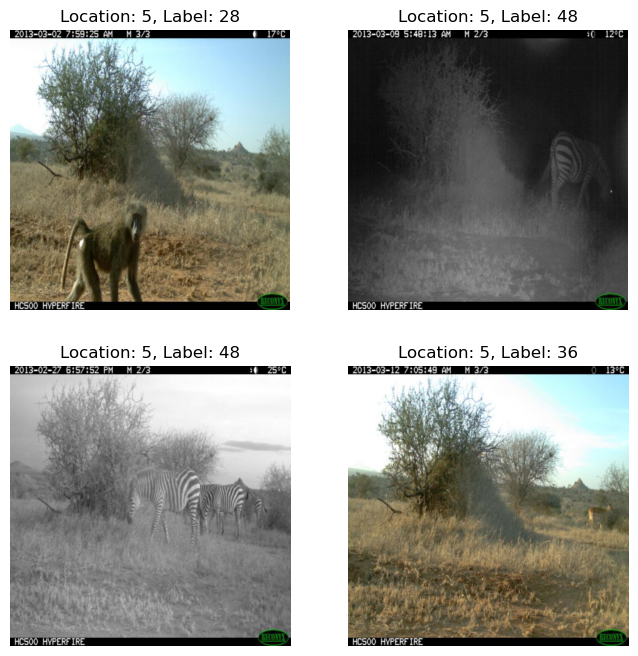

In [ ]:
for x, y_true, metadata in train_location_5_loader:
    z = grouper.metadata_to_group(metadata)

    # Display 4 images
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i in range(4):
        img = x[i]
        label = y_true[i].item()
        location = z[i].item()

        img_pil = torchvision.transforms.ToPILImage()(img)
        axs[i//2, i%2].imshow(img_pil)
        axs[i//2, i%2].set_title(f"Location: {location}, Label: {label}")
        axs[i//2, i%2].axis('off')

    plt.show()
    break

## Data Augmentation:
#### One of the key methods is robust data augmentation. This involves artificially creating variations in your training data to simulate potential real-world variations

In [ ]:
# calculate the mean and std for next step's augmentation pipeline

def compute_mean_std(loader):
    mean = 0
    std = 0
    total_images_count = 0

    for images, _, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = compute_mean_std(train_location_5_loader)
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.3810, 0.3783, 0.3429]), Std: tensor([0.1650, 0.1744, 0.1919])


In [ ]:
from torchvision import transforms

# Define a robust augmentation pipeline
augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

#### we can't revise the original dataset from iWild directly, so we write a custom class to reliaze the augmentation method in train data

In [ ]:
from torch.utils.data import Dataset

class TransformedDataset(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label, metadata = self.base_dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, metadata

In [ ]:
# Redefine the train and test loader after augmentation
total_size = len(location_5_dataset)

test_size = int(0.2 * total_size)  # 20% for testing
train_size = total_size - test_size

train_subset, test_subset = random_split(location_5_dataset, [train_size, test_size])

test_location_5_loader = DataLoader(test_subset, batch_size=16, shuffle=False)

In [ ]:
transformed_dataset = TransformedDataset(train_subset, transform=augmentation)

train_location_5_loader = DataLoader(transformed_dataset, batch_size=16, shuffle=True)

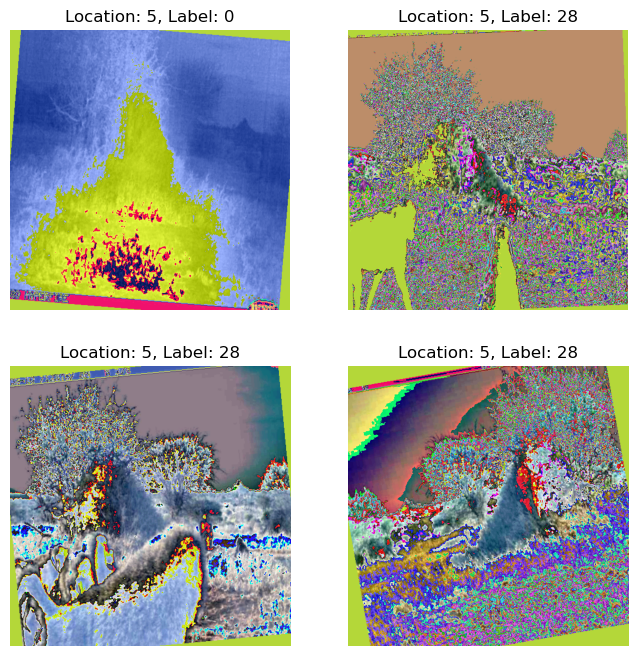

In [ ]:
# display 4 images after augmentation
for x, y_true, metadata in train_location_5_loader:
    z = grouper.metadata_to_group(metadata)

    # Display 4 images
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i in range(4):
        img = x[i]
        label = y_true[i].item()
        location = z[i].item()

        img_pil = torchvision.transforms.ToPILImage()(img)
        axs[i//2, i%2].imshow(img_pil)
        axs[i//2, i%2].set_title(f"Location: {location}, Label: {label}")
        axs[i//2, i%2].axis('off')

    plt.show()
    break

## Regularization Techniques:
#### Implement regularization techniques to prevent overfitting and to help the model generalize better to unseen data.

In [ ]:
# load the model at location 5 from PC
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
model.load_state_dict(torch.load(f"model_location_5.pth"))
model.eval()

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=802816, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=182, bias=True)
)

In [ ]:
# L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

## Adversarial Training:

In [ ]:
def fgsm(image, alpha, data_grad):
    perturbed_image = image + alpha * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, min=0, max=1)
    return perturbed_image

## Training with Augmented Data:

In [ ]:
alpha = 0.1
epoches = 5

for epoch in range(epoches):
    for inputs, labels, metadata in train_location_5_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        inputs.requires_grad = True
        outputs = model(inputs)
        loss = F.nll_loss(outputs, labels)

        model.zero_grad()

        loss.backward()

        data_grad = inputs.grad.data
        perturbed_images = fgsm(inputs, alpha, data_grad)

        output = model(perturbed_images)

        loss_perturbed = F.nll_loss(output, labels)

        model.zero_grad()
        loss_perturbed.backward()

        optimizer.step()

# Save the trained model
torch.save(model.state_dict(), f"model_location_5_OOD.pth")

## Test the accuracy after OOD

In [ ]:
model.eval()

correct_adv = 0
total_adv = 0
alpha = 0.001

for inputs, labels, _ in test_location_5_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    inputs.requires_grad = True

    outputs = model(inputs)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    data_grad = inputs.grad.data
    perturbed_data = fgsm(inputs, alpha, data_grad)

    inputs.requires_grad = False

    with torch.no_grad():
        outputs_adv = model(perturbed_data)

        _, predicted = torch.max(outputs_adv.data, 1)
        total_adv += labels.size(0)
        correct_adv += (predicted == labels).sum().item()

accuracy_adv = correct_adv / total_adv
print(f'Accuracy on adversarial test data: {accuracy_adv:.4f}')

Accuracy on adversarial test data: 0.2680


### Failure conclusion:
### It is obvious that our model has a lower accuracy, there are several reasons for this:
### FIrst, since we use FGSM and pick alpha = 0.1, which will cause a lot of noise in the images, the model will overfit to these noise.
### Second, the weakness of our current CNN model that can't capature all the features in such a complex dataset.
### Based on the fail experience, we will try to implement the second fine tuning OOD method by setting the alpha in adversial training lower and choose a better model.

# tune the paramters in augmentation

In [ ]:
"""
The mean and std here refers to the set in
Out-of-Domain Robustness via Targeted Augmentations[Online]: https://arxiv.org/abs/2302.11861v2
"""
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
from torchvision import transforms

# Define a new augmentation pipeline
augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
transformed_dataset = TransformedDataset(train_subset, transform=augmentation)
train_location_5_loader = DataLoader(transformed_dataset, batch_size=16, shuffle=True)

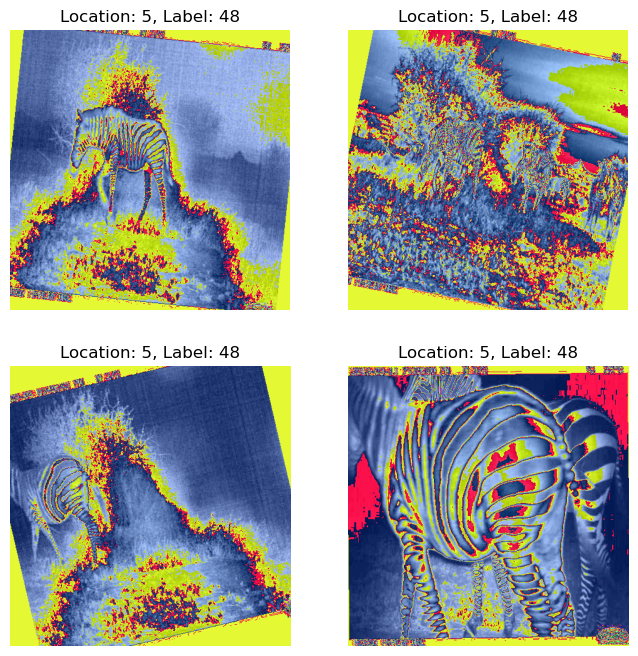

In [ ]:
# display 4 images after augmentation

for x, y_true, metadata in train_location_5_loader:
    z = grouper.metadata_to_group(metadata)

    # Display 4 images
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i in range(4):
        img = x[i]
        label = y_true[i].item()
        location = z[i].item()

        img_pil = torchvision.transforms.ToPILImage()(img)
        axs[i//2, i%2].imshow(img_pil)
        axs[i//2, i%2].set_title(f"Location: {location}, Label: {label}")
        axs[i//2, i%2].axis('off')

    plt.show()
    break

# enhanced CNN model

Add one more convolution layer and batch normalization in the model to enhance the ability to capture features <br>
Add dropout layer to avoid overfitting.

In [ ]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512 * 28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 182)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EnhancedModel = EnhancedCNN().to(device)

In [ ]:
# increasing the number of epoches
epoches = 10
optimizer = torch.optim.Adam(EnhancedModel.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
for epoch in range(epoches):
    EnhancedModel.train()
    for inputs, labels, metadata in train_location_5_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = EnhancedModel(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()

# Save the trained model
torch.save(EnhancedModel.state_dict(), f"EnhancedModel_5.pth")

In [ ]:
model = EnhancedCNN().to(device)
model.load_state_dict(torch.load(f"EnhancedModel_5.pth"))
model.eval()

EnhancedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=401408, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=182, bias=True)
)

In [ ]:
model.eval()

correct_adv = 0
total_adv = 0
alpha = 0.001

for inputs, labels, _ in test_location_5_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    inputs.requires_grad = True

    outputs = model(inputs)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    data_grad = inputs.grad.data
    perturbed_data = fgsm(inputs, alpha, data_grad)

    inputs.requires_grad = False

    with torch.no_grad():
        outputs_adv = model(perturbed_data)

        _, predicted = torch.max(outputs_adv.data, 1)
        total_adv += labels.size(0)
        correct_adv += (predicted == labels).sum().item()

accuracy_adv = correct_adv / total_adv
print(f'Accuracy on adversarial test data: {accuracy_adv:.4f}')

Accuracy on adversarial test data: 0.3024


# step3: GAN model to generate images

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torchvision.models as models

In this part, we try to figure out how to use GAN model generate the feature from one image.
Because of the limited time, we decide to focus on training a GAN model capture the features of label 48 (zebra) from location 5.

**1**  <br>
#### Split the data from location 5 into label 48

In [ ]:
# location_5_ = [i for i, (_, _, metadata) in enumerate(train_data) if metadata[0].item() == 5]
# location_5_dataset = torch.utils.data.Subset(train_data, location_5_)
# location5_data_loader = DataLoader(location_5_dataset, batch_size=16, shuffle=True)

In [ ]:
label_48_ = [i for i, (_, label, metadata) in enumerate(transformed_dataset) if label.item() == 48]
label_48_data = torch.utils.data.Subset(transformed_dataset, label_48_ )
label_48_dataloader = DataLoader(label_48_data, batch_size=16, shuffle=False)

# label_0_ = [i for i, (_, label, metadata) in enumerate(location_5_dataset) if label.item() == 48]
# label_0_data = torch.utils.data.Subset(location_5_dataset, label_48_ )
# label_0_dataloader = DataLoader(label_0_data, batch_size=16, shuffle=False)

In [ ]:
label_48_images = []
label_0_images = []

for images, labels, _ in location5_data_loader:
    for image, label in zip(images, labels):
        if label.item() == 48:
            label_48_images.append(image)
        elif label.item() == 0:
            label_0_images.append(image)

In [ ]:
for images in label_48_images:
    print(images[0].size())
    break
for images in label_0_images:
    print(images[0].size())
    break

torch.Size([448, 448])
torch.Size([448, 448])


In [ ]:
# extract the features from images with label 48

resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
resnet.eval()

def extract_features(data_loader, model):
    features = []
    with torch.no_grad():
        for images, _, _ in data_loader:
            outputs = model(images)
            features.extend(outputs.cpu().detach().numpy())
    return features

label_48_features = extract_features(label_48_dataloader, resnet)

In [ ]:
import pickle

with open('label_48_features.pkl', 'wb') as file:
    pickle.dump(label_48_features, file)

print("Features saved to 'label_48_features.pkl'")

Features saved to 'label_48_features.pkl'


**2** <br>
#### GAN design

The discriminator's job is to differentiate between real and fake images, while the generator's goal is to create images that are indistinguishable from real images.

1. Generator

In [ ]:
with open('label_48_features.pkl', 'rb') as file:
    label_48_features = pickle.load(file)

**LeakyReLU: LeakyReLU(x)=max(αx,x), helps in ensuring that gradients do not become sparse during training, which is a common challenge in GAN** <br>
**Tanh ensures that the generated images have pixel values within the same range as the real images**

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, feature_dim, output_dim):
        super(ConditionalGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + feature_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self, noise, features):
        x = torch.cat([noise, features], dim=1)
        return self.model(x)

2. Discriminator
The Discriminator will take an image as input and output a single value representing whether it thinks the image is real or generated.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 448 * 448, 1024),  # Adjusted input dimension
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

**3** <br>
#### Training

In [ ]:
import random
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/Colab Notebooks/'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# parameters
noise_dim = 5
feature_dim = 1
output_dim = 3 * 448 * 448

# initialize the models if it is the first time
generator = ConditionalGenerator(noise_dim, feature_dim, output_dim).to(device)
discriminator = Discriminator().to(device)

# from the second time, load the model from google drive(keep the above because it creates the model structure)
generator_path = drive_path + "generator_state.pth"
discriminator_path = drive_path + "discriminator_state.pth"

generator.load_state_dict(torch.load(generator_path, map_location=device))
discriminator.load_state_dict(torch.load(discriminator_path, map_location=device))

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))

# Binary Cross-Entropy Loss
adversarial_loss = torch.nn.BCELoss()

# load features
label_48_features = torch.tensor(label_48_features).float().to(device)

batch_size = 16
epochs = 75

Mounted at /content/drive


<ipython-input-19-fdb1fedb5c1b>:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  label_48_features = torch.tensor(label_48_features).float().to(device)


#### Training process

**real_labels: A tensor of ones, signifying that the images are real.** <br>
**fake_labels: A tensor of zeros, indicating that the images are generated (fake)**<br>
**The discriminator is trained twice in each loop: once with real images and once with fake images generated by the generator.** <br>
**The generator's goal is to fool the discriminator. It generates images using the same random noise and features.** <br>

The training loop is designed to achieve a balance where the generator produces realistic images, and the discriminator is adept at distinguishing real from fake.

In [ ]:
for epoch in range(epochs):
    for i, (imgs, labels, _) in enumerate(label_48_dataloader):

        current_batch_size = imgs.size(0)

        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        real_imgs = imgs.to(device)

        # Train the Discriminator:

        optimizer_D.zero_grad()

        real_validity = discriminator(real_imgs).to(device)
        d_loss_real = adversarial_loss(real_validity, real_labels)

        # Generate noise
        z = torch.randn(current_batch_size, noise_dim).to(device)

        batch_features = label_48_features[i * batch_size: (i + 1) * batch_size]

        # here we need to flatten the batch size from 4 to 2
        fake_features = batch_features[:, 0, 0, 0].view(current_batch_size, 1).to(device)

        # Generate fake images with both noise and features
        fake_imgs = generator(z, fake_features)


        fake_validity = discriminator(fake_imgs.detach())
        d_loss_fake = adversarial_loss(fake_validity, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train the Generator:

        optimizer_G.zero_grad()

        generated_imgs = generator(z, fake_features)
        fake_validity = discriminator(generated_imgs)
        g_loss = adversarial_loss(fake_validity, real_labels)

        g_loss.backward()
        optimizer_G.step()

drive_path = '/content/drive/My Drive/Colab Notebooks/'

torch.save(generator.state_dict(), drive_path + "generator_state.pth")
torch.save(discriminator.state_dict(), drive_path + "discriminator_state.pth")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = '/content/drive/My Drive/Colab Notebooks/'

torch.save(generator.state_dict(), drive_path + "generator_state.pth")
torch.save(discriminator.state_dict(), drive_path + "discriminator_state.pth")

In [ ]:
torch.save(generator.state_dict(), "generator_state.pth")
torch.save(discriminator.state_dict(), "discriminator_state.pth")

**4**
#### Generate

In [ ]:
generator = ConditionalGenerator(noise_dim, feature_dim, output_dim).to(device)
discriminator = Discriminator().to(device)

generator.load_state_dict(torch.load(drive_path + "generator_state.pth"))
discriminator.load_state_dict(torch.load(drive_path + "discriminator_state.pth"))

<All keys matched successfully>

In [ ]:
generator.eval()

ConditionalGenerator(
  (model): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=1024, out_features=602112, bias=True)
    (10): Tanh()
  )
)

In [ ]:
noise = torch.randn(1, noise_dim)

with open('label_48_features.pkl', 'rb') as file:
    label_48_features = pickle.load(file)

label_48_feature = label_48_features[0]
label_48_feature = torch.tensor(label_48_feature).float().unsqueeze(0)

In [ ]:
with torch.no_grad():
    generated_image = generator(noise, label_48_feature.view(1, -1)[:, :1]).view(3, 448, 448)  # Reshape to image dimensions
    generated_image = (generated_image + 1) / 2  # Rescale to [0, 1] if your output uses Tanh activation

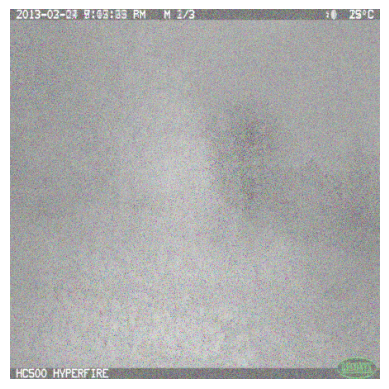

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

generated_image_np = generated_image.detach().cpu().numpy()
generated_image_np = np.transpose(generated_image_np, (1, 2, 0))

plt.imshow(generated_image_np)
plt.axis('off')
plt.show()